In [ ]:
""" Today we're going to use our PyTorch training loop to tackle classification
Remember that our pipeline consists of:
- Preparing a dataset
- Splitting into train data and test data
- Creating a model and defining its parameters
- Running the training loop:
  - Forward pass
  - Calculate loss
  - Zero the optimizer gradients
  - Perform backpropagation
  - Step the optimizer to update the weights
"""


In [1]:
from sklearn.datasets import make_circles

# 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [2]:
# We always want to VISUALIZE the data to help us understand it. We're
# going to put it in a pandas dataframe.
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


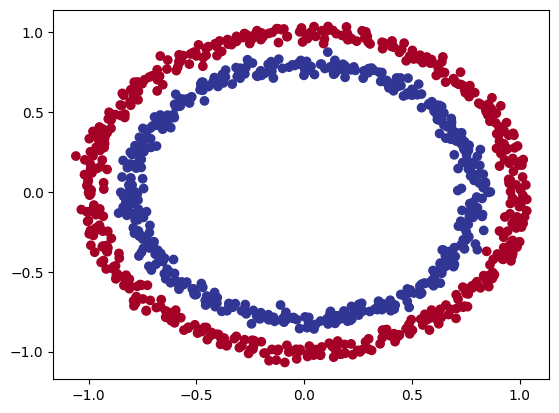

In [9]:
# Now we can plot them 🙂
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [10]:
# One common issue in doing machine learning is mismatched shapes
# So we should always inspect the shape of our data
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Q: What can we conclude from this?

A. We have two features in our input, and our output is a scalar (one feature).

In [12]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# No need to manually split everything up anymore. We've got sklearn for this!
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [16]:
# Time to set up the model
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
class CircleModelA(nn.Module):
  def __init__(self):
    super().__init__()
    """Create two linear layers. The first layer must take in 2 features,
    because that's what the input has, and the second layer must output
    1 feature, because that's what the output has. BUT in between,
    aka the output of the first layer and the input of the second later,
    we can have whatever we want - these are called hidden units, and they're
    a hyperparameter. These are also called NEURONS. """
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_A = CircleModelA().to(device)
model_A


CircleModelA(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_A.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0643, -0.1841],
                      [-0.6187,  0.1721],
                      [ 0.0451,  0.5616],
                      [-0.4811, -0.0396],
                      [ 0.5998, -0.0401]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.1887, -0.2652,  0.3890,  0.1471, -0.0418], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.3846,  0.0177, -0.2762, -0.2708,  0.2548]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2272], device='cuda:0'))])

In [51]:
# We can do the same thing with the built-in nn.Sequential
# that just processes stuff through layers
model_A = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_A

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
untrained_preds = model_A(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4223],
        [-0.3796],
        [-0.5247],
        [-0.3933],
        [-0.5093],
        [-0.4834],
        [-0.3752],
        [-0.3995],
        [-0.5252],
        [-0.3765]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
# This is harder because our predictions come in the form of floats,
# and our labels are 0-1. We will fix this later. First, let's create a
# loss function and an optimizer.

In [52]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_A.parameters(), lr=0.1)

In [36]:
# Now we need an evaluation metric - another way to measure
# how accurate the model is.
def accuracy_fn(y_true, y_pred):
  # torch.eq calculates where two tensors are equal
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [22]:
# Now we follow up from earlier and transform from
# model outputs -> predicted labels By converting between
# 1. Raw Model outputs (called logits, just floats)
# 2. Label prediction probabilities (floats between 0 and 1)
# Predicted labels (round the probabilities somehow)

# Here's an example of some logits
y_logits = model_A(X_test.to(device))[:5]
y_logits

tensor([[-0.4223],
        [-0.3796],
        [-0.5247],
        [-0.3933],
        [-0.5093]], device='cuda:0', grad_fn=<SliceBackward0>)

In [23]:
# Now we can use sigmoid to get them between 0 and 1
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3960],
        [0.4062],
        [0.3718],
        [0.4029],
        [0.3753]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [30]:
y_preds = torch.round(y_pred_probs)
# Complete conversion from logits -> labels
y_pred_labels = torch.round(torch.sigmoid(model_A(X_test.to(device))[:5]))
# print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [31]:
y_test[:5]
# Note we actually don't need to do this whole thing always because
# our loss function nn.BCEWithLogitsLoss() works on raw logits;
# it has a sigmoid function built in. Also, the use of sigmoid activation
# really only works for binary classification (0,1). For multi-class,
# where your output will be a vector, you will use softmax.

tensor([1., 0., 1., 0., 1.])

In [53]:
# Training loop time.
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_A = model_A.to(device)

for epoch in range(epochs):
  model_A.train()

  # Forward pass
  y_logits = model_A(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Test it!
  model_A.eval()
  with torch.inference_mode():
    test_logits = model_A(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
  if epoch < 10:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.73556, Accuracy: 50.50% | Test loss: 0.72743, Test acc: 51.00%
Epoch: 1 | Loss: 0.73130, Accuracy: 52.62% | Test loss: 0.72368, Test acc: 51.50%
Epoch: 2 | Loss: 0.72752, Accuracy: 54.50% | Test loss: 0.72035, Test acc: 55.00%
Epoch: 3 | Loss: 0.72417, Accuracy: 56.25% | Test loss: 0.71741, Test acc: 56.50%
Epoch: 4 | Loss: 0.72121, Accuracy: 57.00% | Test loss: 0.71480, Test acc: 58.00%
Epoch: 5 | Loss: 0.71857, Accuracy: 58.00% | Test loss: 0.71248, Test acc: 58.00%
Epoch: 6 | Loss: 0.71623, Accuracy: 58.88% | Test loss: 0.71042, Test acc: 58.50%
Epoch: 7 | Loss: 0.71414, Accuracy: 58.50% | Test loss: 0.70859, Test acc: 57.00%
Epoch: 8 | Loss: 0.71229, Accuracy: 56.88% | Test loss: 0.70697, Test acc: 56.00%
Epoch: 9 | Loss: 0.71063, Accuracy: 55.88% | Test loss: 0.70552, Test acc: 55.00%


In [57]:
# Wow, that SUCKS! It's barely better than random guessing.
# Let's examine why by visualizing it.

In [58]:
# Import some helper functions for pyplot
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


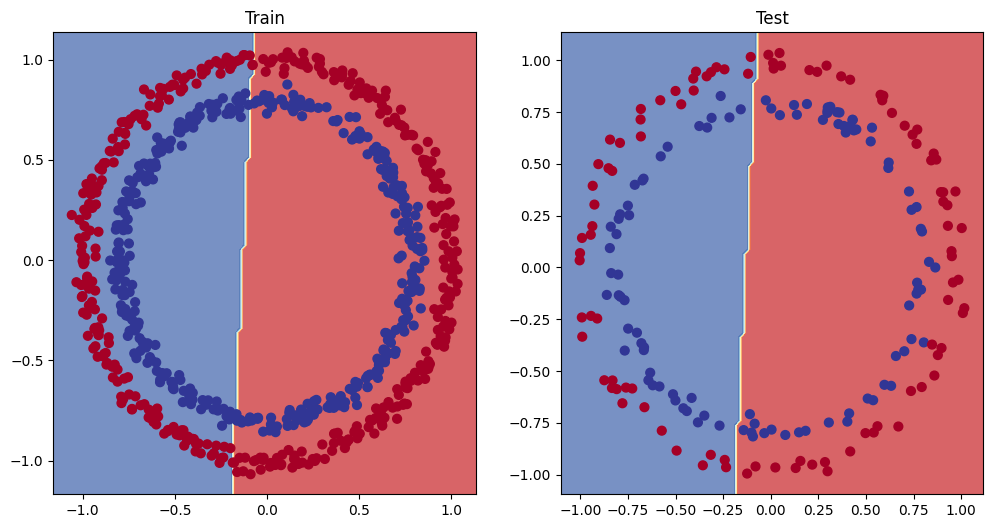

In [59]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_A, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_A, X_test, y_test)

In [ ]:
# It's trying to split the red and blue dots using a straight line.
# First, let's try adding another layer and increasing the epochs.

In [60]:
model_B = nn.Sequential(nn.Linear(in_features=2, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)).to(device)
model_B

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [61]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.1)

In [62]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_B.train()

  # Forward pass
  y_logits = model_B(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Test it!
  model_B.eval()
  with torch.inference_mode():
    test_logits = model_B(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69723, Accuracy: 50.00% | Test loss: 0.69679, Test acc: 50.00%
Epoch: 100 | Loss: 0.69301, Accuracy: 50.88% | Test loss: 0.69462, Test acc: 45.50%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.25% | Test loss: 0.69474, Test acc: 47.50%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69474, Test acc: 47.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69472, Test acc: 46.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69470, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69469, Test acc: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69469, Test acc: 45.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69468, Test acc: 45.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69468, Test acc: 45.00%


In [63]:
# Didn't do any better. Let's examine why:

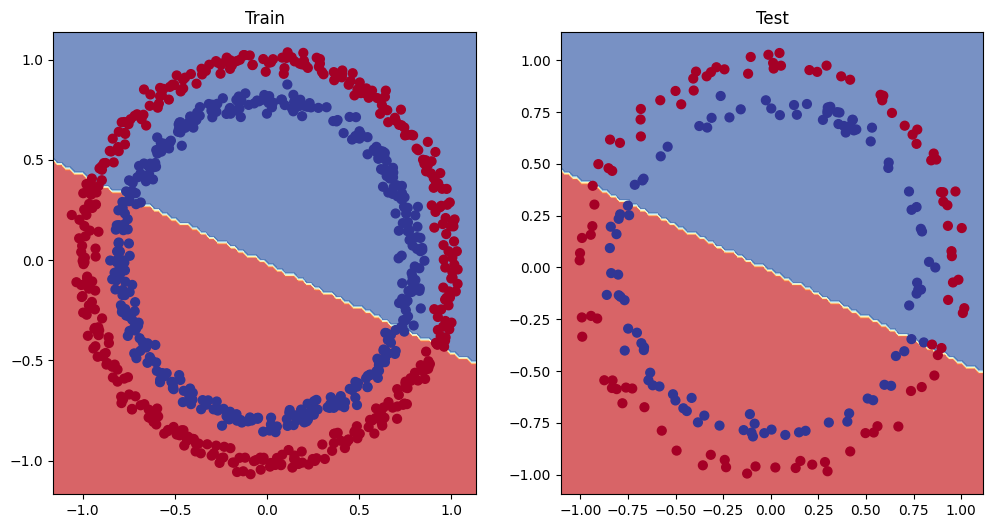

In [66]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_B, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_B, X_test, y_test)

In [ ]:
# The missing piece is NON-LINEARITY. We need to able to
# fit to non-linear decision boundaries!

In [73]:
model_C = nn.Sequential(nn.Linear(in_features=2, out_features=20),
                        nn.ReLU(),
                        nn.Linear(in_features=20, out_features=20),
                        nn.ReLU(),
                        nn.Linear(in_features=20, out_features=1)).to(device)
model_C

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
)

In [74]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_C.parameters(), lr=0.1)

In [75]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_C.train()

  # Forward pass
  y_logits = model_C(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # Test it!
  model_C.eval()
  with torch.inference_mode():
    test_logits = model_C(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69379, Accuracy: 50.00% | Test loss: 0.69397, Test acc: 50.00%
Epoch: 100 | Loss: 0.69014, Accuracy: 52.12% | Test loss: 0.69122, Test acc: 47.50%
Epoch: 200 | Loss: 0.68591, Accuracy: 61.75% | Test loss: 0.68827, Test acc: 56.00%
Epoch: 300 | Loss: 0.67861, Accuracy: 60.88% | Test loss: 0.68405, Test acc: 54.50%
Epoch: 400 | Loss: 0.66598, Accuracy: 62.25% | Test loss: 0.67572, Test acc: 55.50%
Epoch: 500 | Loss: 0.64786, Accuracy: 64.00% | Test loss: 0.66234, Test acc: 57.00%
Epoch: 600 | Loss: 0.61456, Accuracy: 72.50% | Test loss: 0.63357, Test acc: 65.00%
Epoch: 700 | Loss: 0.54523, Accuracy: 93.50% | Test loss: 0.57184, Test acc: 85.00%
Epoch: 800 | Loss: 0.41793, Accuracy: 99.75% | Test loss: 0.45621, Test acc: 98.50%
Epoch: 900 | Loss: 0.26031, Accuracy: 99.88% | Test loss: 0.30642, Test acc: 99.50%


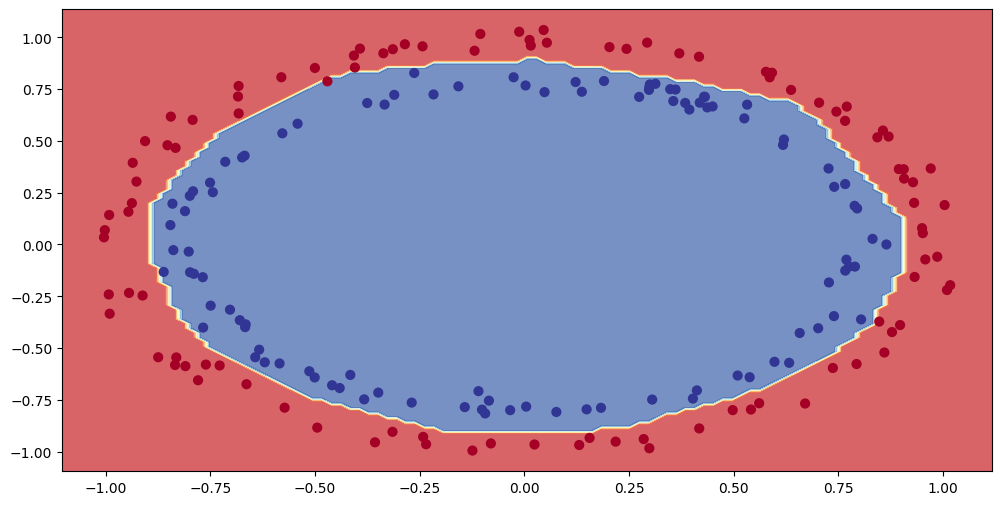

In [76]:
plt.figure(figsize=(12, 6))
plot_decision_boundary(model_C, X_test, y_test)

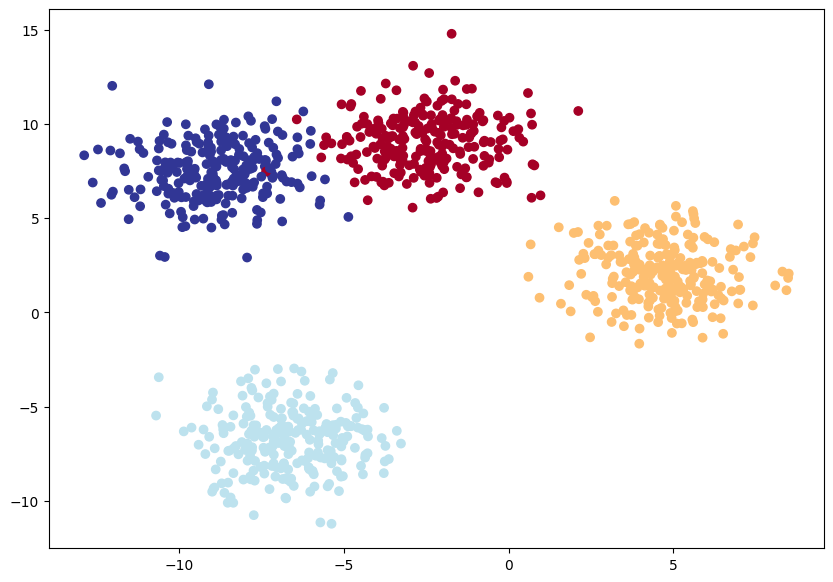

In [87]:
# Now we will apply the same approach to multi-class classification

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set some constants for our dataset
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

# Turn the data into tensors and split it
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:
model_D = nn.Sequential(nn.Linear(in_features=2, out_features=8),
                        nn.Linear(in_features=8, out_features=8),
                        nn.Linear(in_features=8, out_features=4)).to(device)
model_D

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=8, bias=True)
  (2): Linear(in_features=8, out_features=4, bias=True)
)

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_D.parameters(), lr=0.1)

In [92]:
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_D.train()

    # 1. Forward pass
    y_logits = model_D(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_D.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_D(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.15694, Acc: 12.12% | Test Loss: 0.59476, Test Acc: 64.00%
Epoch: 10 | Loss: 0.13149, Acc: 99.00% | Test Loss: 0.11913, Test Acc: 99.00%
Epoch: 20 | Loss: 0.07764, Acc: 98.88% | Test Loss: 0.06950, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05903, Acc: 98.88% | Test Loss: 0.05136, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04982, Acc: 99.00% | Test Loss: 0.04206, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04440, Acc: 99.00% | Test Loss: 0.03645, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04087, Acc: 99.00% | Test Loss: 0.03272, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03840, Acc: 99.00% | Test Loss: 0.03006, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03659, Acc: 99.00% | Test Loss: 0.02807, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03521, Acc: 99.00% | Test Loss: 0.02652, Test Acc: 99.50%


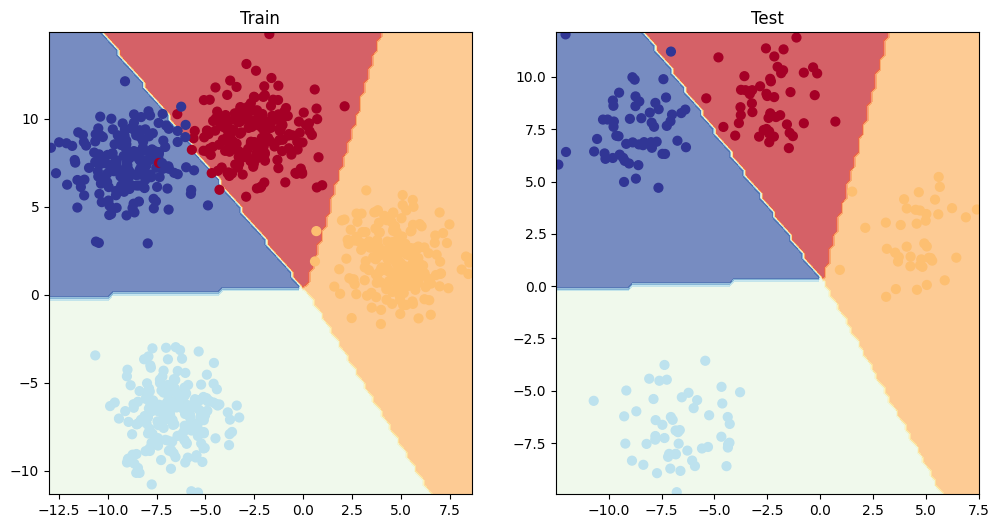

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_D, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_D, X_blob_test, y_blob_test)